In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect("steam.db")

games = pd.read_sql("SELECT * FROM games", conn)
stats = pd.read_sql("SELECT * FROM stats", conn)

conn.close()


### Organize the "owners"(from range string to the minimum number)

In [3]:
games["owners_min"] = games["owners"].str.extract(r"(\d+)").astype(float)


## 1. Top 15 games
### owners

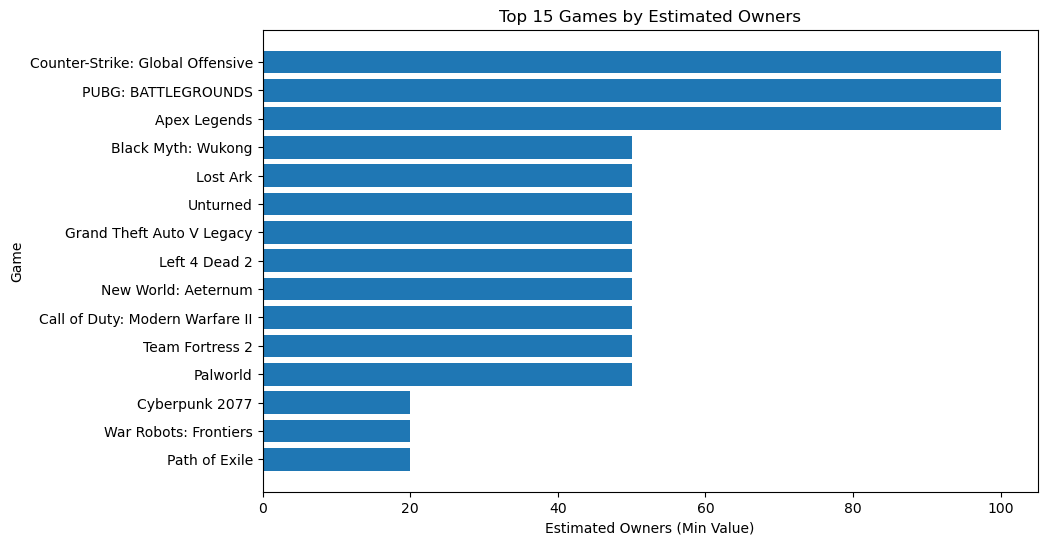

In [4]:
top_owners = games.sort_values("owners_min", ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top_owners["name"], top_owners["owners_min"])
plt.xlabel("Estimated Owners (Min Value)")
plt.ylabel("Game")
plt.title("Top 15 Games by Estimated Owners")
plt.gca().invert_yaxis()
plt.show()


### lifetime playtime

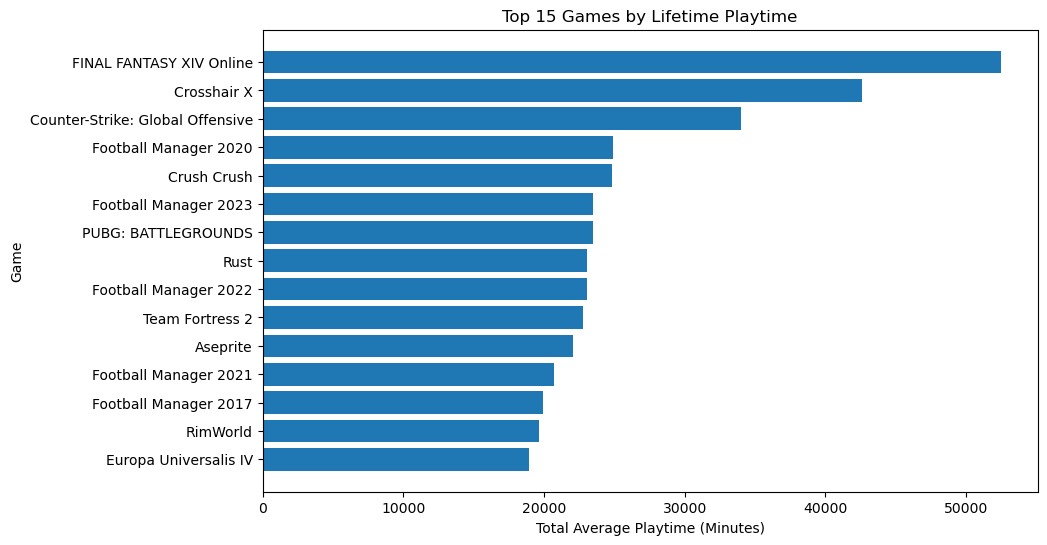

In [5]:
top_forever = games.sort_values("average_forever", ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top_forever["name"], top_forever["average_forever"])
plt.xlabel("Total Average Playtime (Minutes)")
plt.ylabel("Game")
plt.title("Top 15 Games by Lifetime Playtime")
plt.gca().invert_yaxis()
plt.show()


### Most active(during past 2 weeks)

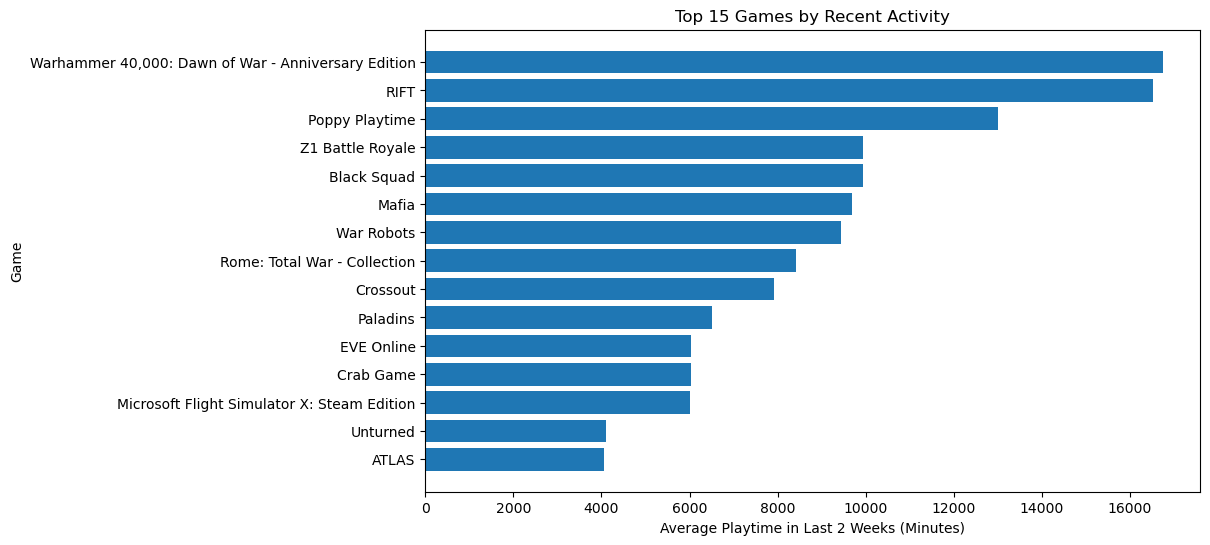

In [6]:
top_2weeks = games.sort_values("average_2weeks", ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top_2weeks["name"], top_2weeks["average_2weeks"])
plt.xlabel("Average Playtime in Last 2 Weeks (Minutes)")
plt.ylabel("Game")
plt.title("Top 15 Games by Recent Activity")
plt.gca().invert_yaxis()
plt.show()


#### Data shows~
Games with the largest player bases (e.g., CS:GO, PUBG, Apex Legends) dominate ownership numbers.
But they are not always the games with the longest total playtime.

#### Insight

Popularity does not equal longevity.
Games that truly have long term engagement are often:

- Strategy / simulation games

- MMOs

- Deep sandbox games

These games rely on content depth.

#### Data shows~~

The average_2weeks metric often behaves very differently from lifetime playtime:
- Some games have high lifetime playtime but low recent activity .. aging titles
- Some have huge recent activity spikes .. new season, patch, DLC, or community event

#### Insight

Two categories matter most:

- Short-term spikes:
High 2-week playtime but average lifetime playtime
..Indicates successful updates or temporary hype

- Long-term stable performers:
High lifetime and high 2-week playtime
..This group defines the platform’s core engagement drivers

## 2. Achievement Difficulty Analysis (Lowest Average Unlock Percentage = Highest Difficulty)

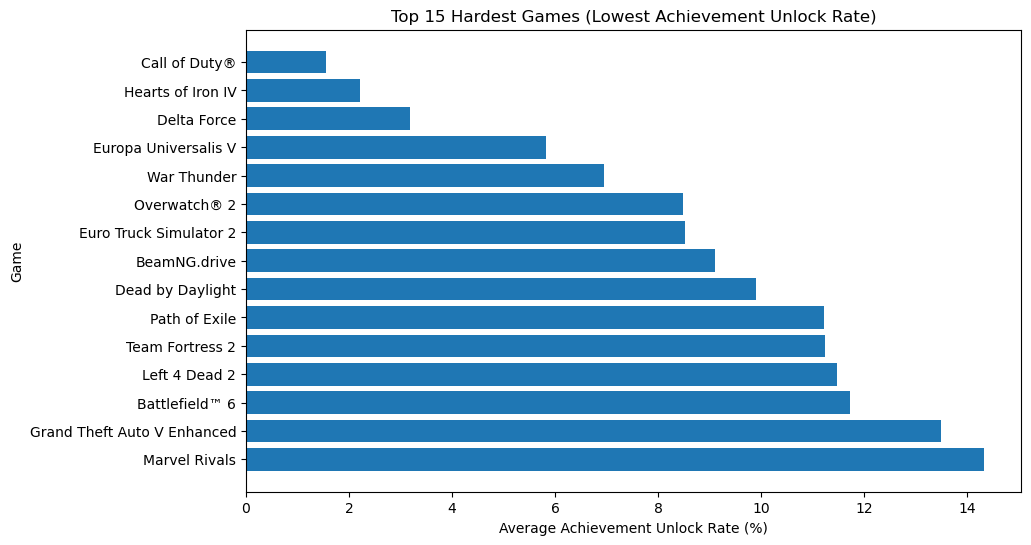

In [7]:
stats["percent_unlocked"] = stats["percent_unlocked"].astype(float)

difficulty = (
    stats.groupby("game_name")["percent_unlocked"]
    .mean()
    .sort_values()
    .head(15)
)

plt.figure(figsize=(10,6))
plt.barh(difficulty.index, difficulty.values)
plt.xlabel("Average Achievement Unlock Rate (%)")
plt.ylabel("Game")
plt.title("Top 15 Hardest Games (Lowest Achievement Unlock Rate)")
plt.gca().invert_yaxis()
plt.show()


## 3. Simple scatter plot of owners (player size) vs. average_forever (player stickiness)

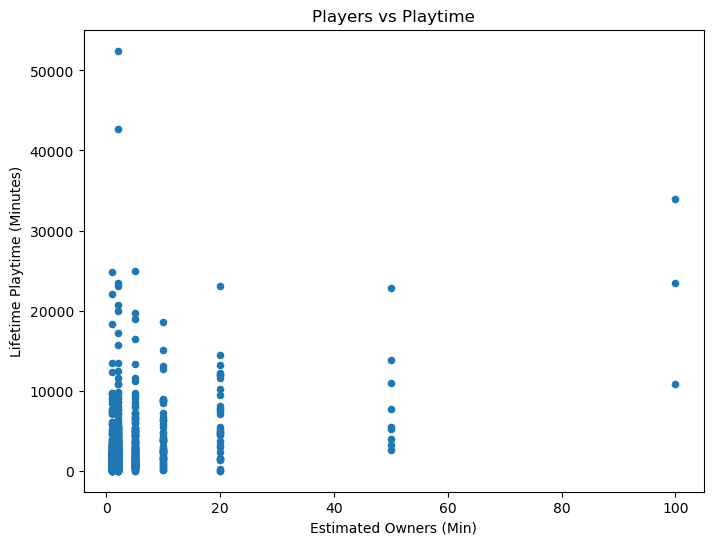

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(games["owners_min"], games["average_forever"], s=20)
plt.xlabel("Estimated Owners (Min)")
plt.ylabel("Lifetime Playtime (Minutes)")
plt.title("Players vs Playtime")
plt.show()


#### Data shows~

three clusters:

1. High Owners, High Playtime

Examples: CS:GO; GTA V; DOTA 2

Characteristics:

- Massive player base
- Strong retention
- High community value

2. High Owners, Low Playtime —— F2P(free-to-play) Hits

Typically:

- F2P
- Strong hype in short term
- no depth

Best for:

- Onboarding
- Promotions
- Seasonal events

3. Low Owners, High Playtime —— Extremely Deep Games

Typically:

- Strategy
- Simulation
- Crafting
- Hardcore RPGs

for:

- Smaller audience
- But exceptionally high engagement per player
- loyal fans

## Make a new table merging "stats" and "games"
### also average version of it

In [9]:
merged = stats.merge(
    games[["appid", "name", "average_forever", "average_2weeks", "owners"]],
    on="appid",
    how="left"
)

merged["owners_min"] = merged["owners"].str.extract(r"(\d+)").astype(float)

merged["percent_unlocked"] = merged["percent_unlocked"].astype(float)

merged_summary = merged.groupby(
    ["appid", "name"],
    as_index=False
).agg({
    "percent_unlocked": "mean",
    "average_forever": "mean"
})


## 4. Playtime VS Achievement Unlock Rate

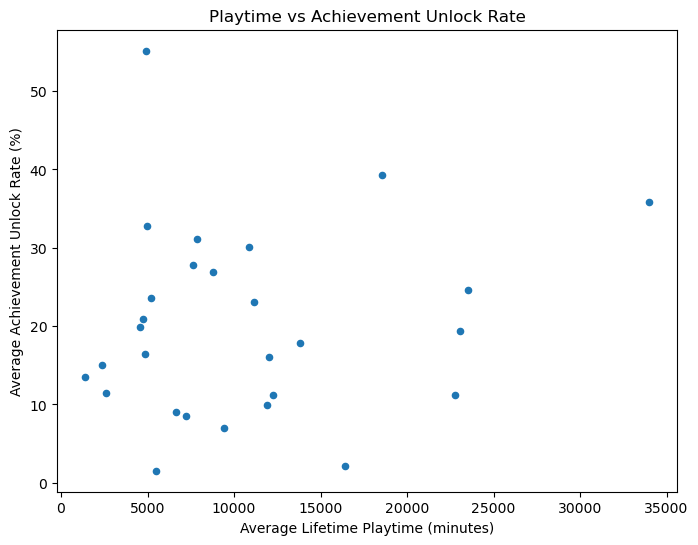

In [10]:
ach_playtime = merged.groupby("name").agg({
    "percent_unlocked": "mean",
    "average_forever": "mean"
}).reset_index()

plt.figure(figsize=(8,6))
plt.scatter(
    ach_playtime["average_forever"],
    ach_playtime["percent_unlocked"],
    s=20
)
plt.xlabel("Average Lifetime Playtime (minutes)")
plt.ylabel("Average Achievement Unlock Rate (%)")
plt.title("Playtime vs Achievement Unlock Rate")
plt.show()


#### Data shows~~~

Some games have extremely low achievement completion rates
Others have very high unlock percentages

#### Insight

Achievement unlock rate presents difficulty and game depth.

- Low unlock % .. complex systems, high skill floor, large content depth

- High unlock % ..beginner-friendly, more casual, easier progression

This metric is valuable for segmentation:

- Hardcore ecosystem games

- ust Single playthrough “experience games”

## 5. GAMES most played but low achievements unlocked

In [11]:
avg_unlock = merged_summary["percent_unlocked"].mean()
med_playtime = merged_summary["average_forever"].median()

hardcore_games = merged_summary[
    (merged_summary["percent_unlocked"] < avg_unlock) &
    (merged_summary["average_forever"] > med_playtime)
].sort_values(by="average_forever", ascending=False).head(10)

print("GAMES most played but low achievements unlocked")
print(hardcore_games)


GAMES most played but low achievements unlocked
     appid                       name  percent_unlocked  average_forever
9   252490                       Rust         19.378261          23071.0
0      440            Team Fortress 2         11.235000          22769.0
15  394360          Hearts of Iron IV          2.204819          16395.0
11  271590  Grand Theft Auto V Legacy         17.902597          13824.0
7   238960              Path of Exile         11.212598          12247.0
5   230410                   Warframe         16.006736          12008.0
14  381210           Dead by Daylight          9.898958          11896.0
6   236390                War Thunder          6.947778           9438.0


#### Insight

These games have very deep mechanics and large time investment but with incredibly low achievement completion.
We call them hardcore evergreen? games on Steam.

- High retention

- High lifetime value

- Strong community ecosystem

like strategy, sandbox, open world type.

## 6. GAMES easy achievements but less played

In [12]:
avg_unlock = merged_summary["percent_unlocked"].mean()
med_playtime = merged_summary["average_forever"].median()

easy_lessplay = merged_summary[
    (merged_summary["percent_unlocked"] > avg_unlock) &
    (merged_summary["average_forever"] < med_playtime)
].sort_values(by="percent_unlocked", ascending=False).head(10)

print("GAMES easy achievements but less played")
print(easy_lessplay)


GAMES easy achievements but less played
      appid             name  percent_unlocked  average_forever
18   553850     HELLDIVERS 2         55.157895           4904.0
13   322170    Geometry Dash         32.758333           4999.0
3    105600         Terraria         31.167826           7889.0
21  1086940  Baldur's Gate 3         27.816667           7607.0
22  1091500   Cyberpunk 2077         23.575439           5218.0
16   413150   Stardew Valley         20.900000           4761.0


#### Insight

Games that players complete easily but don’t play for long are:

- New-player friendly

- Highly marketable?(maybe not)

- Great for discount events

Strong at driving user acquisition, not long term retention.

## 7. Correlation check

In [13]:
corr_df = merged_summary[["average_forever", "percent_unlocked"]]
print(corr_df.corr())



                  average_forever  percent_unlocked
average_forever          1.000000          0.138215
percent_unlocked         0.138215          1.000000


#### Insight

How long players play a game has almost nothing to do with how many achievements they unlock.

This means the two metrics represent different behavior patterns:

- Playtime = engagement / retention

- Achievements = difficulty / progression style